<h1> Imports </h1>

In [1]:
from read_data import read_dataset_1, translate_1, read_dataset_3, translate_3
from models import SimulationEnvironment
from optimizer import BaseGA, SimpleAgentGA
from agent import GreedyAgent, AgentSimulator
from visualize import reformat_result, visualize, visualize_schedule, fitness_history_plot
import random
import copy

<h1>Parameters</h1>


In [2]:
# Parameters
max_generations = 20
earliest_time_slot = 200
last_time_slot = 5000
population_size = 10
offspring_amount = 20

order_amount = 10

<h1>Input Data</h1>
<h4>Choose 1 of the following</h4>

Dataset 1 (Job Shop Scheduling)

In [3]:
input, orders, instance = read_dataset_1(use_instance=2, order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_1(instance, orders, earliest_time_slot, last_time_slot)

Dataset 3, Resource Constrained (Job Shop Scheduling)

In [4]:
input, orders, instance = read_dataset_3(order_amount=order_amount, earliest_time=earliest_time_slot, last_time=last_time_slot)
recipes, workstations, resources, tasks, orders_model = translate_3(instance, n_workstations=10, generated_orders=orders, earliest=earliest_time_slot, latest=last_time_slot) # for dataset 3, the amount of available machines has to be declared (not included with the data)

<h1> Simulation Environment Setup </h1>

In [4]:
env = SimulationEnvironment(workstations, tasks, resources, recipes)

<h1>Optimizer</h1>

Config 1 - Test with One Point Crossover

Current generation: 0, Current Best: 77, not feasible
Current generation: 1, Current Best: 77, not feasible
Current generation: 2, Current Best: 77, not feasible
Current generation: 3, Current Best: 76, not feasible
Current generation: 4, Current Best: 75, not feasible
Current generation: 5, Current Best: 74, not feasible
Current generation: 6, Current Best: 73, not feasible
Current generation: 7, Current Best: 73, not feasible
Current generation: 8, Current Best: 72, not feasible
Current generation: 9, Current Best: 72, not feasible
Current generation: 10, Current Best: 72, not feasible
Current generation: 11, Current Best: 72, not feasible
Current generation: 12, Current Best: 72, not feasible
Current generation: 13, Current Best: 71, not feasible
Current generation: 14, Current Best: 71, not feasible
Current generation: 15, Current Best: 71, not feasible
Current generation: 16, Current Best: 71, not feasible
Current generation: 17, Current Best: 71, not feasible
Current generation: 

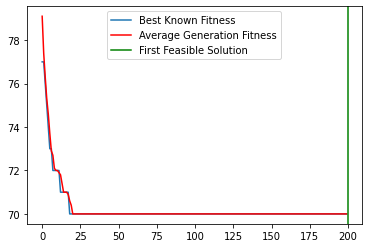

In [5]:
optimizer = BaseGA(env)
optimizer.set_minimize()
# optional (in this case, all options given are the default option, if the configuration step is skipped)
optimizer.configure('tardiness', 'onepointcrossover', 'roulettewheel', 'randomize')
# choose an input generator (optional) -> decides how the data gets converted into the optimizer format
# optimizer.set_input_generator('SameLengthAlternativesGenerator')
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 2 - Test with Two Point Crossover

Current generation: 0, Current Best: 79, not feasible
Current generation: 1, Current Best: 79, not feasible
Current generation: 2, Current Best: 78, not feasible
Current generation: 3, Current Best: 77, not feasible
Current generation: 4, Current Best: 76, not feasible
Current generation: 5, Current Best: 76, not feasible
Current generation: 6, Current Best: 76, not feasible
Current generation: 7, Current Best: 75, not feasible
Current generation: 8, Current Best: 74, not feasible
Current generation: 9, Current Best: 73, not feasible
Current generation: 10, Current Best: 72, not feasible
Current generation: 11, Current Best: 72, not feasible
Current generation: 12, Current Best: 72, not feasible
Current generation: 13, Current Best: 71, not feasible
Current generation: 14, Current Best: 71, not feasible
Current generation: 15, Current Best: 71, not feasible
Current generation: 16, Current Best: 71, not feasible
Current generation: 17, Current Best: 71, not feasible
Current generation: 

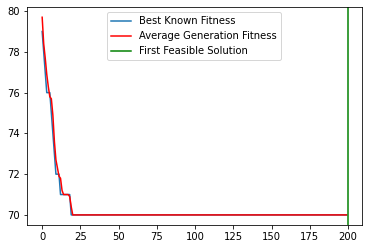

In [6]:
optimizer = BaseGA(env)
optimizer.set_minimize()
# optional (in this case, all options given are the default option, if the configuration step is skipped)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'randomize')
# choose an input generator (optional) -> decides how the data gets converted into the optimizer format
#optimizer.set_input_generator('SameLengthAlternativesGenerator')
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 3 - Only valid mutations for time slots

Current generation: 0, Current Best: 70, not feasible
Current generation: 1, Current Best: 70, not feasible
Current generation: 2, Current Best: 70, not feasible
Current generation: 3, Current Best: 70, not feasible
Current generation: 4, Current Best: 70, not feasible
Current generation: 5, Current Best: 70, not feasible
Current generation: 6, Current Best: 70, not feasible
Current generation: 7, Current Best: 70, not feasible
Current generation: 8, Current Best: 70, not feasible
Current generation: 9, Current Best: 70, not feasible
Current generation: 10, Current Best: 70, not feasible
Current generation: 11, Current Best: 70, not feasible
Current generation: 12, Current Best: 70, not feasible
Current generation: 13, Current Best: 70, not feasible
Current generation: 14, Current Best: 70, not feasible
Current generation: 15, Current Best: 70, not feasible
Current generation: 16, Current Best: 70, not feasible
Current generation: 17, Current Best: 70, not feasible
Current generation: 

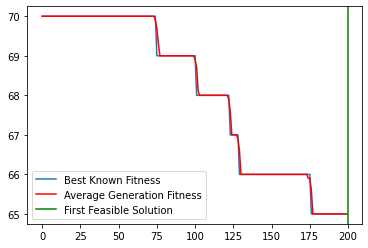

In [7]:
optimizer = BaseGA(env)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'onlyfeasibletimeslot')
last_time_slot = 0
for order in orders:
    if order[1] > last_time_slot:
        last_time_slot = order[1]
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

Config 4 - Randomized Mutation with "open" Planning Horizon

Current generation: 0, Current Best: 75, not feasible
Current generation: 1, Current Best: 75, not feasible
Current generation: 2, Current Best: 75, not feasible
Current generation: 3, Current Best: 75, not feasible
Current generation: 4, Current Best: 73, not feasible
Current generation: 5, Current Best: 73, not feasible
Current generation: 6, Current Best: 73, not feasible
Current generation: 7, Current Best: 72, not feasible
Current generation: 8, Current Best: 72, not feasible
Current generation: 9, Current Best: 71, not feasible
Current generation: 10, Current Best: 71, not feasible
Current generation: 11, Current Best: 70, not feasible
Current generation: 12, Current Best: 70, not feasible
Current generation: 13, Current Best: 70, not feasible
Current generation: 14, Current Best: 70, not feasible
Current generation: 15, Current Best: 70, not feasible
Current generation: 16, Current Best: 70, not feasible
Current generation: 17, Current Best: 70, not feasible
Current generation: 

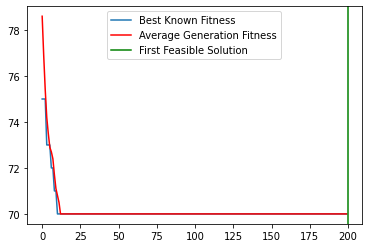

In [8]:
optimizer = BaseGA(env)
optimizer.configure('tardiness', 'twopointcrossover', 'roulettewheel', 'randomize')
last_time_slot = 0
for order in orders:
    if order[1] > last_time_slot:
        last_time_slot = order[1]
# all parameters after offspring_amount are optional (in this case -> verbose=True)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
workstation_assignments = reformat_result(result, orders, env)
visualize(workstation_assignments, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen)

<h1> Agents </2>

Greedy

In [20]:
agent = GreedyAgent(env)
simulator = AgentSimulator()
schedule, schedule_count = simulator.simulate(agent, orders_model)
print(f'Scheduled {schedule_count}/{len(orders_model)} Orders')
visualize_schedule(schedule, env)

Scheduled 10/10 Orders


Greedy with changing sequence

In [21]:
def change_order(orders):
    p1 = random.randint(0, len(orders) -2)
    p2 = random.randint(p1, len(orders) -1)
    selected = copy.deepcopy(orders[p1 : p2 +1])
    selected.reverse()
    for i in range(len(selected)):
        orders[p1 + i] = copy.deepcopy(selected[i])

agent = GreedyAgent(env)
simulator = AgentSimulator()
n_generations = 10
best = None
sequence = copy.deepcopy(orders_model)
for gen in range(n_generations):
    simulator = AgentSimulator()
    schedule, schedule_count = simulator.simulate(agent, sequence)
    if not best or best[1] < schedule_count:
        best = [schedule, schedule_count, copy.deepcopy(sequence)]
    change_order(sequence)
print(f'Scheduled {best[1]}/{len(best[2])} Orders')
visualize_schedule(best[0], env)



Scheduled 10/10 Orders


Greedy with order sequence optimization

In [22]:
agent = GreedyAgent(env)
simulator = AgentSimulator()
sequence = copy.deepcopy(orders_model)
optimizer = SimpleAgentGA(env, agent, simulator)
optimizer.configure('ordercount', 'onepointcrossover', 'roulettewheel', 'orderchange', 'agent') # change individual type
optimizer.evaluation_method.set_simulator(simulator)
optimizer.evaluation_method.set_agent(agent)
optimizer.set_maximize()
optimizer.set_sequence(sequence)
result, best_fitness_history, average_fitness_history, best_generation_history, feasible_gen = optimizer.optimize(orders, max_generations, earliest_time_slot, last_time_slot, population_size, offspring_amount, verbose=True)
schedule, schedule_count = simulator.simulate(agent, result.genes)
print(f'Scheduled {schedule_count}/{len(orders_model)} Orders')
# for some reason visualization is very slow on this one
#visualize_schedule(schedule, env)
#fitness_history_plot(best_fitness_history, average_fitness_history, feasible_gen, best_generation_history)

Current generation: 0, Current Best: 10, not feasible
Current generation: 1, Current Best: 10, not feasible
Current generation: 2, Current Best: 10, not feasible
Current generation: 3, Current Best: 10, not feasible
Current generation: 4, Current Best: 10, not feasible
Current generation: 5, Current Best: 10, not feasible
Current generation: 6, Current Best: 10, not feasible
Current generation: 7, Current Best: 10, not feasible
Current generation: 8, Current Best: 10, not feasible
Current generation: 9, Current Best: 10, not feasible
Current generation: 10, Current Best: 10, not feasible
Current generation: 11, Current Best: 10, not feasible
Current generation: 12, Current Best: 10, not feasible
Current generation: 13, Current Best: 10, not feasible
Current generation: 14, Current Best: 10, not feasible
Current generation: 15, Current Best: 10, not feasible
Current generation: 16, Current Best: 10, not feasible
Current generation: 17, Current Best: 10, not feasible
Current generation: 